In [1]:
# @hidden_cell
# import some libraries
import numpy as np                # for vector, matrix etc data structures and manipulations
import matplotlib.pyplot as plt   # for plotting
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# The Fundamental Model in Computational Chemistry

## Motivation

The goal of much of computational chemistry is to predict the properties of chemical systems from information about their chemical makeup and system properties.  Since properties of molecules depend on their structure, determining system properties boils down to determining molecular structure (or ensembles of molecular structures).  The ***fundamental model*** in computational chemistry is that the structure/ensembles of molecules depend on their potential (/free) energy surfaces.  How you define/describe the potential energy of a molecule depends on the properties you are trying to determine.  In this course we will focus on two main ways of estimating the potential energy surfaces: quantum mechanics and molecular mechanics.

## Learning Objectives

After working through this notebook, you will be able to:

1. Define the fundamental model of computational chemistry
2. Identify two methods for computing the potential energy of chemical systems
3. Identify methods for determinging molecular structure from potential energy functions of chemical systems

## Coding Concepts

The following coding concepts are employed in this notebook:

1. Variables
2. Functions
3. Plotting

## The Potential Energy Surface

We use the potential energy surface picture to describe chemical processes in general chemistry.  Consider the reversible reaction

\begin{equation}
A(g) \rightleftharpoons B(g). 
\end{equation}

If $A$ and $B$ readily interconvert but there is more $A$ at equilibrium, we can represent that behavior with an energy diagram such as

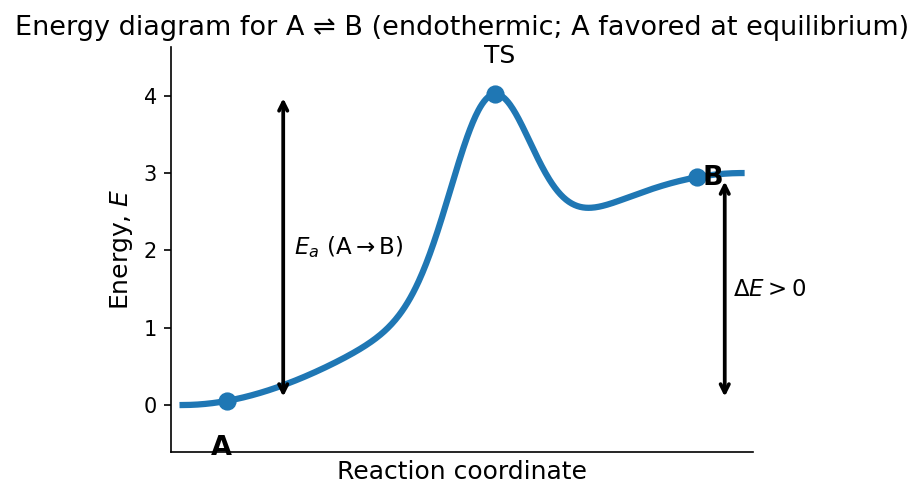

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Parameters you can tweak ----------
E_A  = 0.0      # energy of A
E_B  = 3.0      # energy of B (higher than A => endothermic)
E_TS = 4.0      # transition state energy
x_TS = 0.55     # location of TS along reaction coordinate (0..1)
# --------------------------------------------

# Build a smooth "double-well-ish" curve that hits A, TS, and B
x = np.linspace(0, 1, 600)

# Use a cubic baseline that matches endpoints plus a Gaussian bump for TS
baseline = E_A + (E_B - E_A) * (3*x**2 - 2*x**3)  # smoothstep from A to B
bump = (E_TS - (E_A + (E_B - E_A) * (3*x_TS**2 - 2*x_TS**3))) * np.exp(-((x - x_TS)/0.10)**2)
E = baseline + bump

# Points for annotation
A_pt  = (0.08, np.interp(0.08, x, E))
B_pt  = (0.92, np.interp(0.92, x, E))
TS_ix = np.argmax(E)
TS_pt = (x[TS_ix], E[TS_ix])

# Plot
fig, ax = plt.subplots(figsize=(5, 3.5), dpi=150)
ax.plot(x, E, linewidth=3)

# Markers
ax.scatter([A_pt[0], TS_pt[0], B_pt[0]],
           [A_pt[1], TS_pt[1], B_pt[1]],
           s=60, zorder=3)

# Labels for states
ax.text(A_pt[0]-0.03, A_pt[1]-0.7, "A", fontsize=13, weight="bold")
ax.text(B_pt[0]+0.01, B_pt[1]-0.1, "B", fontsize=13, weight="bold")
ax.text(TS_pt[0]-0.02, TS_pt[1]+0.4, "TS", fontsize=12)

# Helper function for vertical brackets
def vbracket(xpos, y0, y1, label, xtext_offset=0.015):
    ax.annotate(
        "", xy=(xpos, y1), xytext=(xpos, y0),
        arrowprops=dict(arrowstyle="<->", lw=1.8)
    )
    ax.text(xpos + xtext_offset, 0.5*(y0+y1), label, va="center", fontsize=11)

# ΔE (endothermic): energy difference A -> B
vbracket(0.97, A_pt[1], B_pt[1], r"$\Delta E > 0$")

# Activation energy forward: A -> TS
vbracket(0.18, A_pt[1], TS_pt[1], r"$E_a$ (A$\rightarrow$B)", xtext_offset=0.02)

# ΔG° positive (equilibrium favors A)
# We show it qualitatively as A lower than B
#ax.text(0.60, min(E)+0.6, r"$\Delta G^\circ > 0$  (equilibrium favors A)", fontsize=11)

# Cosmetics
ax.set_xlabel("Reaction coordinate", fontsize=12)
ax.set_ylabel("Energy, $E$", fontsize=12)
ax.set_title("Energy diagram for A ⇌ B (endothermic; A favored at equilibrium)", fontsize=13)

ax.set_xticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.margins(x=0.02, y=0.15)

plt.show();

This energy diagram represents the potential energy as a function of the reaction coordinate (RC).  The total potential energy of the system depends on many more variables than the RC but the RC is an important coordinate that connects states $A$ and $B$.  

In general, the function $E$ depends on the coordinates of, at least, all of the nuclei (atoms) and electrons of the system.  Computational chemistry is split into two main ways of approximating this function: quantum mechanics and molecular mechanics.  It should also be noted that these two methods typically address different questions.

### Quantum Mechanics

In quantum mechanics, the energy of a system is a function of the nuclei and the electrons of a system.  Since electrons are small, their behavior is governed by quantum mechanics rather than classical mechanics.  As such, we must solve for the energy using the Schrödinger equation
\begin{equation}
\hat{H}\Psi = E\Psi,
\end{equation}
where $\hat{H}$ is the Hamiltonian, $\Psi$ is the wavefunction, and $E$ is the energy of the system.  This equation typically represents a partial differential equation that depends on all of the particles comprising the system.  Solving this equation can be cumbersome and typically requires approximations that we will discuss at a later time.

Many codes have been developed to solve approximations of the Schrödinger equation for chemical systems.  These codes are often referred to as electronic structure codes.  Examples include Gaussian, Qchem, GAMESS, and others.  Additionally, there are other more specifc use codes developed to do various other things within quantum mechanics that are beyond the scope of this class.

### Molecular Mechanics

In molecular mechanics, the energy of the system is a function of the nuclei of the systems (there are some variants that get slightly more complicated but generally this is the case).  The electrons are averaged or integrated out meaning they are dealt with directly in the energy function.  This allows one to treat the system using classical mechanics, as opposed to quantum mechanics.  

A common molecular mechanics model is to describe a molecule as a collection of bonds, angles and dihedral (1-2-3-4) interactions.  Additionally, each atom is ascribed a excluded volume, polarization, and point charge.  In such a model, the potential energy of the system can be defined as:
\begin{align}
E_{\text{tot}}
&= E_{\text{bond}} + E_{\text{angle}} + E_{\text{dihedral}} + E_{\text{nonbond}}
\\[4pt]
E_{\text{bond}}
&= \sum_{\text{bonds } ij} k_{r,ij}\,\bigl(r_{ij}-r^{0}_{ij}\bigr)^{2}
\\[4pt]
E_{\text{angle}}
&= \sum_{\text{angles } ijk} k_{\theta,ijk}\,\bigl(\theta_{ijk}-\theta^{0}_{ijk}\bigr)^{2}
\\[4pt]
E_{\text{dihedral}}
&= \sum_{\text{torsions } ijkl}\;\sum_{n}
\frac{V_{n,ijkl}}{2}\,
\Bigl[1+\cos\!\bigl(n\phi_{ijkl}-\gamma_{n,ijkl}\bigr)\Bigr]
\\[4pt]
E_{\text{nonbond}}
&= \sum_{i<j}^{\text{nonbonded}}
\left[
4\epsilon_{ij}\left(\frac{\sigma_{ij}}{r_{ij}}\right)^{12}
-4\epsilon_{ij}\left(\frac{\sigma_{ij}}{r_{ij}}\right)^{6}
+ \frac{q_i q_j}{4\pi\varepsilon_0\, r_{ij}}
\right]
\\[4pt]
\end{align}
This is a fairly standard form for a classical model of a molecule and in the field the specific functional form chosen as well as defining the associated parameters is called a force field.  The parameters of each term must be determined/defined to specificy a particular model of a molecule.  Other functional forms can be used but this is a typical energy function.

There are a variety of force fields to describe molecules but some of the most common are Amber, CHARMM, OPLS, and gromos.  Each force field has typically been parameterized for specific systems so it is very important to make sure you are applying the force field to an appropriate system.  Codes used to apply parameters as well as calculate associate energies inlcude Amber, NAMD, CHARMM, and Gromacs.

## Determing Structure(s) from Energy Functions

With an energy function defined, either using quantum mechanics or molecular mechanics, we must determine the structure or structures that are important for a particular chemical system or process.  

On of the most trivial ways of doing this is to ***determine the stationary points*** of the function.  Stationary points of a function are the local maxima and minima of the surface.  That is, when
\begin{equation}
\frac{d E}{d \vec{R}} = 0
\end{equation}
where $\vec{R}$ are the coordinates of all things being considered in the energy function (i.e. nuclei and electrons or just nuclei).  There are a variety of methods to determine the positions ($\vec{R}$) that satisfy this equation.  The simplest is to just differentiate the function $E$ w.r.t. $\vec{R}$ analytically, set equal to zero, and solve for $\vec{R}$.  This is not always feasible for high dimensional $\vec{R}$ and/or complicated functions $E$.  There are numerical methods for determining these as well as other approximations that we may discuss as the semester goes on.  The method of determining stationary points is most commonly employed in conjunction with quantum mechanical methods (though it is also used for molecular mechanics to some degree).  

Another method for determining structures from an energy function is to ***sample*** from the energy function.  The most common methods to achieve sampling are Monte Carlo and Molecular Dynamics.  These methods are used to determine a set of plausible structures from the underlying energy function but they also have a variety of drawbacks and limitations that we will discuss.  Sampling many structures can be computationally demanding/expensive and thus is most typically employed with molecular mechanics (cheap) models.  This is not always the case, however, as more and more sampling is being done on quantum mechanical models.

Despite the success of Planck's model for the blackbody radiation, the idea the energy is quantized in certain situations was not generally accepted.  Around 1887, a german physicist by the name of Heinrich Hertz discovered what is now called the photoelectric effect: shining ultraviolet light at a metallic surface causes electrons to be emitted from the surface.  Two observations made during this experiment were in contrast with classical theory.  Namely that the energy of the emitted electrons is independent of the intensity of the incident light and that there is a threshold frquency of incident light below which no electrons are ejected from the surface.  These results could not be explained by classical mechanics.  Albert Einstein attempted to explain this phenomenon by first quantizing the energy levels of the electrons similar to what Planck did:

$ E = nh\nu. \tag{3} $

Einstein took this one step further and suggested that the light energy emitted was also quantized packets of energy, now known as photons (Planck assumed the emitted light was a classical wave).  These suggests lead to the conclusion that the kinetic energy of emitted light will have the following form:

$KE = h\nu - h\nu_0. \tag{4}$

This result was able to explain the experiment.  The above equation demonstrates that the kinetic energy of the emitted electron will be equal to the energy (not intensity) of the incident light minus a threshold energy which is also called a work function.  

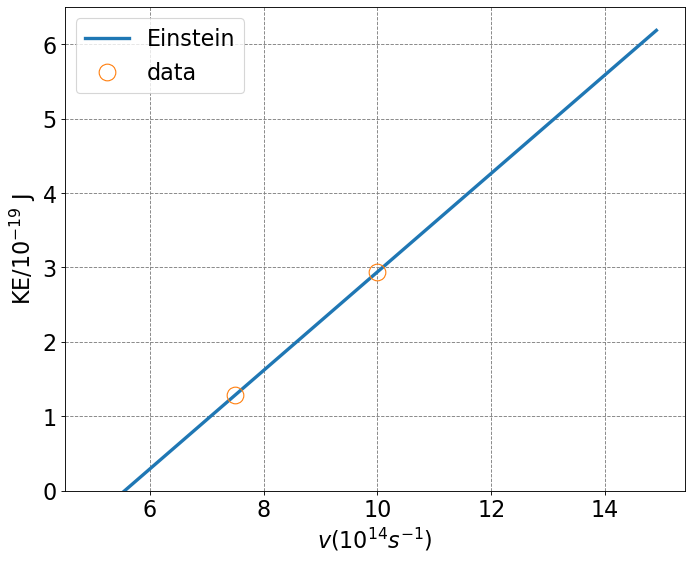

In [50]:
# Photoelectric effect for Lithium
h = 6.626e-1  # converted unites
c = 3.0E8      # m/s

v0 = 5.564 # E14 for Lithium

# quantum spectral distribution function
def photoelectric(x):
    return h*x - h*v0

# initialize a figure
ax = define_figure(xlabel='$ v (10^{14}s^{-1})$',ylabel="KE$/10^{-19}$ J")
# make an array containing domain of wavelengths to consider
x = np.arange(5.0,15,0.1)
plt.ylim((0.0,np.amax(photoelectric(x))*1.05))
# plot quantum result
ax.plot(x,photoelectric(x),label="Einstein",lw=3)
xdata = [c/300E-9*1E-14,c/400E-9*1E-14]
ydata = [2.935,1.280]
ax.plot(xdata,ydata,'o',markersize=15,mfc='none',label='data')
ax.plot()
# make legend
ax.legend(fontsize=20,markerscale=1.0);